In [2]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
#         # 1 input image channel, 6 output channels, 5x5 square convolution
#         # kernel
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         # Max pooling over a (2, 2) window
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square, you can specify with a single number
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()
# print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32))]
     )

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [4]:
batch_size = 64

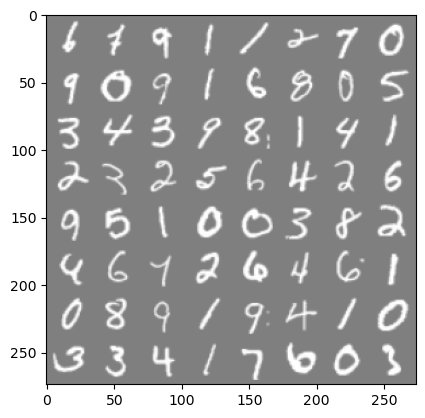

    6     7     9     1     1     2     7     0     9     0     9     1     6     8     0     5     3     4     3     9     8     1     4     1     2     3     2     5     6     4     2     6     9     5     1     0     0     3     8     2     4     6     7     2     6     4     6     1     0     8     9     1     9     4     1     0     3     3     4     1     7     6     0     3


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 184)
        self.fc2 = nn.Linear(184, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable params: " + str(pytorch_total_params))

# 61706
# 76256
# 99662
# 89776


Number of trainable params: 88846


In [7]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epochs = 10

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

def train_loop(dataloader, model, loss_fn, optimizer):
    running_loss = 0.0
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        
        # Compute prediction and loss for backprop
        pred = net(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation by setting grad to zero, calculating using backprop engine and stepping (using learning rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    
    # No gradient on training data (faster computation and no optimization happening here anyway)
    with torch.no_grad():
        for X, y in dataloader:
            pred = net(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# for epoch in range(10):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 100 == 99:    # print every 100 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 100))
#             running_loss = 0.0



cuda:0


In [10]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, net, loss_fn, optimizer)
    test_loop(testloader, net, loss_fn)
print('Finished Training')

Epoch 1
-------------------------------
loss: 2.305504  [    0/60000]
loss: 2.292733  [ 6400/60000]
loss: 2.275967  [12800/60000]
loss: 2.251801  [19200/60000]
loss: 2.130375  [25600/60000]
loss: 1.540640  [32000/60000]
loss: 0.484408  [38400/60000]
loss: 0.554527  [44800/60000]
loss: 0.621516  [51200/60000]
loss: 0.700950  [57600/60000]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.006240 

Epoch 2
-------------------------------
loss: 0.490356  [    0/60000]
loss: 0.276534  [ 6400/60000]
loss: 0.406297  [12800/60000]
loss: 0.514172  [19200/60000]
loss: 0.400730  [25600/60000]
loss: 0.289437  [32000/60000]
loss: 0.275140  [38400/60000]
loss: 0.248133  [44800/60000]
loss: 0.114994  [51200/60000]
loss: 0.153377  [57600/60000]
Test Error: 
 Accuracy: 93.5%, Avg loss: 0.003469 

Epoch 3
-------------------------------
loss: 0.288224  [    0/60000]
loss: 0.212992  [ 6400/60000]
loss: 0.184972  [12800/60000]
loss: 0.141342  [19200/60000]
loss: 0.167939  [25600/60000]
loss: 0.206940  [32000/600

In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader_rot:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100.0 * correct / total))

Accuracy of the network on the 10000 test images: 31.950000 %


In [1]:
# prepare to count predictions for each class
correct_pred = {num : 0 for num in range(0, 10)}
total_pred = {num : 0 for num in range(0, 10)}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for num {} is: {:.1f} %".format(classname,
                                                   accuracy))

NameError: name 'torch' is not defined

In [10]:
### Imports
from RotMNIST import RotMNIST

### New instance of CNN for testing on MNIST and RotMNIST
net = Net()
net.to(device)

### Hyperparameters
epochs = 10
learning_rate = 0.001
batch_size = 64


# Optimizers and Objectives
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

### Datasets and Dataloaders
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32))]
     )
dataset_rot = RotMNIST(
    root = 'data',
    download=True,
    train=True,
    transform=transform,
    rotation_mirroring=True
)

test_dataset_rot = RotMNIST(
    root = 'data',
    download=True,
    train=False,
    transform=transform,
    rotation_mirroring=True
)

dataset_upright = RotMNIST(
    root = 'data',
    download=True,
    train=True,
    transform=transform,
    rotation_mirroring=False,
)

### Instantiate dataloader for RotMNIST and get batches
train_dataloader_rot = torch.utils.data.DataLoader(dataset_rot, batch_size=batch_size, shuffle=True)
test_dataloader_rot = torch.utils.data.DataLoader(test_dataset_rot, batch_size=batch_size, shuffle=True)
train_dataloader_upright = torch.utils.data.DataLoader(dataset_upright, batch_size=batch_size, shuffle=True)

In [11]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader_rot, net, loss_fn, optimizer)
    test_loop(test_dataloader_rot, net, loss_fn)
print('Finished Training')

Epoch 1
-------------------------------
loss: 2.305217  [    0/60000]
loss: 2.296696  [ 6400/60000]
loss: 2.293112  [12800/60000]
loss: 2.294113  [19200/60000]
loss: 2.295065  [25600/60000]
loss: 2.278071  [32000/60000]
loss: 2.265457  [38400/60000]
loss: 2.223956  [44800/60000]
loss: 2.120625  [51200/60000]
loss: 1.505598  [57600/60000]
Test Error: 
 Accuracy: 27.4%, Avg loss: 0.036824 

Epoch 2
-------------------------------
loss: 1.200164  [    0/60000]
loss: 0.745467  [ 6400/60000]
loss: 0.519635  [12800/60000]
loss: 0.599424  [19200/60000]
loss: 0.524786  [25600/60000]
loss: 0.370485  [32000/60000]
loss: 0.350423  [38400/60000]
loss: 0.361508  [44800/60000]
loss: 0.539175  [51200/60000]
loss: 0.148360  [57600/60000]
Test Error: 
 Accuracy: 29.4%, Avg loss: 0.072286 

Epoch 3
-------------------------------
loss: 0.197427  [    0/60000]
loss: 0.248409  [ 6400/60000]
loss: 0.179247  [12800/60000]
loss: 0.343159  [19200/60000]
loss: 0.411106  [25600/60000]
loss: 0.194376  [32000/600